# Kaplan-Meier Survival Curves & Sankey Diagram

This notebook builds on the treatment effect analysis to produce:

1. **Kaplan-Meier survival curves** comparing treated vs untreated simulants
   - Set 1: Time zero = BBBM entry (CRN-matched cross-scenario comparison)
   - Set 2: Time zero = treatment decision (within-scenario treated vs refused)
2. **Sankey diagram** explaining why 71.8% of treated simulants show zero benefit

### Events analyzed
- **Progression to MCI** (BBBM exit via disease transition)
- **All-cause death** (any cause)
- **AD-associated death** (death while in dementia state; only dementia has EMR > 0)

In [1]:
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from tqdm.auto import tqdm
from vivarium import InteractiveContext

SPEC_PATH = '../src/vivarium_csu_alzheimers/model_specifications/model_spec.yaml'
POPULATION_SIZE = 10_000
STEP_SIZE_DAYS = 182
STEP_SIZE_YEARS = STEP_SIZE_DAYS / 365.25

BBBM_STATE = 'alzheimers_blood_based_biomarker_state'
MCI_STATE = 'alzheimers_mild_cognitive_impairment_state'
DEMENTIA_STATE = 'alzheimers_disease_state'
DISEASE_COL = 'alzheimers_disease_and_other_dementias'
TREATMENT_COL = 'treatment'

TARGET_YEAR = 2070

## Data Collection

Enhanced tracking function that records:
- BBBM entry/exit times and destinations
- Treatment pipeline entry and state at BBBM exit
- **Disease state at death** for all simulants (to identify AD-associated deaths)
- **Treatment refusal time** (`no_effect_never_treated` entry) for KM Set 2
- **Treatment state at BBBM exit** collected *before* the step (to avoid component-ordering artifacts)

In [2]:
def run_scenario_with_tracking(scenario, target_year=TARGET_YEAR):
    """Run a scenario with enhanced per-simulant tracking for KM and Sankey analysis."""
    sim = InteractiveContext(
        SPEC_PATH,
        configuration={
            'population': {'population_size': POPULATION_SIZE},
            'intervention': {'scenario': scenario},
        }
    )

    target = pd.Timestamp(f'{target_year}-01-01')
    est_steps = max(1, math.ceil((target - sim.current_time).days / STEP_SIZE_DAYS))

    # Per-simulant tracking
    in_bbbm = set()
    alive_set = set()
    bbbm_enter_time = {}      # sid -> first BBBM entry timestamp
    bbbm_exit_time = {}       # sid -> first BBBM exit timestamp
    bbbm_exit_to = {}         # sid -> 'mci' | 'dead'
    death_time = {}           # sid -> death timestamp
    disease_at_death = {}     # sid -> disease state at death
    treatment_pipeline_time = {}  # sid -> first non-susceptible treatment state time
    treatment_refusal_time = {}   # sid -> time entering no_effect_never_treated
    treatment_state_at_exit = {}  # sid -> treatment state when leaving BBBM

    # Snapshot of treatment states BEFORE each step (for accurate exit tracking)
    prev_treatment_states = {}  # sid -> treatment state from previous step

    with tqdm(total=est_steps, desc=scenario.replace('bbbm_', ''), unit='step') as pbar:
        while sim.current_time < target:
            # Capture pre-step treatment states for simulants currently in BBBM
            if scenario == 'bbbm_testing_and_treatment' and in_bbbm:
                pop_pre = sim.get_population()
                alive_pre = pop_pre[pop_pre['alive'] == 'alive']
                for sid in in_bbbm:
                    if sid in alive_pre.index and TREATMENT_COL in alive_pre.columns:
                        prev_treatment_states[sid] = alive_pre.loc[sid, TREATMENT_COL]

            sim.step()
            pop = sim.get_population()
            alive = pop[pop['alive'] == 'alive']
            t = sim.current_time
            current_alive = set(alive.index)

            # Track deaths
            newly_dead = alive_set - current_alive
            for sid in newly_dead:
                if sid not in death_time:
                    death_time[sid] = t
                    # Get disease state from full pop (dead simulants still have columns)
                    if sid in pop.index:
                        disease_at_death[sid] = pop.loc[sid, DISEASE_COL]

            # Track BBBM entry/exit
            currently_bbbm = set(alive.index[alive[DISEASE_COL] == BBBM_STATE])

            new_bbbm = currently_bbbm - in_bbbm
            for sid in new_bbbm:
                if sid not in bbbm_enter_time:
                    bbbm_enter_time[sid] = t

            exited_bbbm = in_bbbm - currently_bbbm
            for sid in exited_bbbm:
                if sid not in bbbm_exit_time:
                    bbbm_exit_time[sid] = t
                    if sid in current_alive:
                        bbbm_exit_to[sid] = 'mci'  # only MCI follows BBBM
                    else:
                        bbbm_exit_to[sid] = 'dead'
                    # Use pre-step treatment state to avoid component-ordering artifacts
                    if sid in prev_treatment_states:
                        treatment_state_at_exit[sid] = prev_treatment_states[sid]
                    elif TREATMENT_COL in pop.columns:
                        treatment_state_at_exit[sid] = pop.loc[sid, TREATMENT_COL]

            in_bbbm = currently_bbbm
            alive_set = current_alive

            # Track treatment pipeline entry and refusal
            if scenario == 'bbbm_testing_and_treatment' and TREATMENT_COL in alive.columns:
                pipeline_states = [
                    'waiting_for_treatment', 'treatment_effect',
                    'waning_effect', 'no_effect_after_treatment',
                ]
                for sid in alive.index:
                    state = alive.loc[sid, TREATMENT_COL]
                    if state in pipeline_states and sid not in treatment_pipeline_time:
                        treatment_pipeline_time[sid] = t
                    if state == 'no_effect_never_treated' and sid not in treatment_refusal_time:
                        treatment_refusal_time[sid] = t

            pbar.update(1)

    return {
        'bbbm_enter_time': bbbm_enter_time,
        'bbbm_exit_time': bbbm_exit_time,
        'bbbm_exit_to': bbbm_exit_to,
        'death_time': death_time,
        'disease_at_death': disease_at_death,
        'treatment_pipeline_time': treatment_pipeline_time,
        'treatment_refusal_time': treatment_refusal_time,
        'treatment_state_at_exit': treatment_state_at_exit,
        'sim_end': sim.current_time,
    }

In [3]:
print('Running testing-only scenario...')
test_data = run_scenario_with_tracking('bbbm_testing')
print(f'  {len(test_data["bbbm_exit_time"])} BBBM exits')
print(f'  {len(test_data["death_time"])} deaths')

print('\nRunning testing+treatment scenario...')
treat_data = run_scenario_with_tracking('bbbm_testing_and_treatment')
print(f'  {len(treat_data["bbbm_exit_time"])} BBBM exits')
print(f'  {len(treat_data["death_time"])} deaths')
print(f'  {len(treat_data["treatment_pipeline_time"])} entered treatment pipeline')
print(f'  {len(treat_data["treatment_refusal_time"])} refused treatment')

Running testing-only scenario...
2026-02-08 09:11:07.703 | INFO     | simulation_1-artifact_manager:79 - Running simulation from artifact located at /home/abie/vivarium_csu_alzheimers/united_states_of_america.hdf.


2026-02-08 09:11:07.704 | INFO     | simulation_1-artifact_manager:80 - Artifact base filter terms are ['draw == 0'].


2026-02-08 09:11:07.705 | INFO     | simulation_1-artifact_manager:81 - Artifact additional filter terms are None.


/home/abie/miniforge3/envs/vivarium_csu_alzheimers_simulation/lib/python3.11/site-packages/vivarium_public_health/plugins/parser.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_filename


2026-02-08 09:11:08.697 | INFO     | simulation_1-results_context:129 - The following stratifications are registered but not used by any observers: 
['current_year', 'semester']


2026-02-08 09:11:08.759 | WARNING  | simulation_1-resource_manager:176 - Resource stream.alzheimers_disease_and_other_dementias_initial_states is not produced by any component but is needed to compute (column.alzheimers_disease_and_other_dementias).


2026-02-08 09:11:08.760 | WARNING  | simulation_1-resource_manager:176 - Resource column.treatment_effect.dwell_time is not produced by any component but is needed to compute (value_modifier.treatment_effect.dwell_time.1.treatment.modify_dwell_time).


2026-02-08 09:11:08.760 | WARNING  | simulation_1-resource_manager:176 - Resource column.waning_effect.dwell_time is not produced by any component but is needed to compute (value_modifier.waning_effect.dwell_time.1.treatment.modify_dwell_time).


2026-02-08 09:11:08.761 | WARNING  | simulation_1-resource_manager:176 - Resource stream.treatment_initial_states is not produced by any component but is needed to compute (null.0).


testing:   0%|          | 0/97 [00:00<?, ?step/s]

2026-02-08 09:11:09.577 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2022-01-01 00:00:00


2026-02-08 09:11:12.020 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2022-07-02 00:00:00


2026-02-08 09:11:14.624 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2022-12-31 00:00:00


2026-02-08 09:11:18.034 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2023-07-01 00:00:00


2026-02-08 09:11:21.881 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2023-12-30 00:00:00


2026-02-08 09:11:27.059 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2024-06-29 00:00:00


2026-02-08 09:11:30.959 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2024-12-28 00:00:00


2026-02-08 09:11:34.633 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2025-06-28 00:00:00


2026-02-08 09:11:38.446 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2025-12-27 00:00:00


2026-02-08 09:11:42.124 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2026-06-27 00:00:00


2026-02-08 09:11:45.464 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2026-12-26 00:00:00


2026-02-08 09:11:50.044 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2027-06-26 00:00:00


2026-02-08 09:11:54.393 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2027-12-25 00:00:00


2026-02-08 09:12:00.189 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2028-06-24 00:00:00


2026-02-08 09:12:04.846 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2028-12-23 00:00:00


2026-02-08 09:12:08.903 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2029-06-23 00:00:00


2026-02-08 09:12:13.363 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2029-12-22 00:00:00


2026-02-08 09:12:17.575 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2030-06-22 00:00:00


2026-02-08 09:12:22.043 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2030-12-21 00:00:00


2026-02-08 09:12:26.479 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2031-06-21 00:00:00


2026-02-08 09:12:32.814 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2031-12-20 00:00:00


2026-02-08 09:12:37.542 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2032-06-19 00:00:00


2026-02-08 09:12:42.247 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2032-12-18 00:00:00


2026-02-08 09:12:46.723 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2033-06-18 00:00:00


2026-02-08 09:12:52.209 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2033-12-17 00:00:00


2026-02-08 09:12:56.811 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2034-06-17 00:00:00


2026-02-08 09:13:01.640 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2034-12-16 00:00:00


2026-02-08 09:13:07.928 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2035-06-16 00:00:00


2026-02-08 09:13:12.996 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2035-12-15 00:00:00


2026-02-08 09:13:17.739 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2036-06-14 00:00:00


2026-02-08 09:13:22.966 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2036-12-13 00:00:00


2026-02-08 09:13:27.890 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2037-06-13 00:00:00


2026-02-08 09:13:32.845 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2037-12-12 00:00:00


2026-02-08 09:13:37.943 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2038-06-12 00:00:00


2026-02-08 09:13:45.321 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2038-12-11 00:00:00


2026-02-08 09:13:50.615 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2039-06-11 00:00:00


2026-02-08 09:13:56.279 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2039-12-10 00:00:00


2026-02-08 09:14:01.622 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2040-06-09 00:00:00


2026-02-08 09:14:06.685 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2040-12-08 00:00:00


2026-02-08 09:14:12.190 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2041-06-08 00:00:00


2026-02-08 09:14:19.567 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2041-12-07 00:00:00


2026-02-08 09:14:26.051 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2042-06-07 00:00:00


2026-02-08 09:14:31.833 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2042-12-06 00:00:00


2026-02-08 09:14:37.326 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2043-06-06 00:00:00


2026-02-08 09:14:43.588 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2043-12-05 00:00:00


2026-02-08 09:14:52.256 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2044-06-04 00:00:00


2026-02-08 09:14:59.174 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2044-12-03 00:00:00


2026-02-08 09:15:05.766 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2045-06-03 00:00:00


2026-02-08 09:15:12.048 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2045-12-02 00:00:00


2026-02-08 09:15:17.803 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2046-06-02 00:00:00


2026-02-08 09:15:25.891 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2046-12-01 00:00:00


2026-02-08 09:15:32.747 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2047-06-01 00:00:00


2026-02-08 09:15:40.317 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2047-11-30 00:00:00


2026-02-08 09:15:47.446 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2048-05-30 00:00:00


2026-02-08 09:15:56.806 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2048-11-28 00:00:00


2026-02-08 09:16:03.178 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2049-05-29 00:00:00


2026-02-08 09:16:09.396 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2049-11-27 00:00:00


2026-02-08 09:16:16.657 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2050-05-28 00:00:00


2026-02-08 09:16:23.249 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2050-11-26 00:00:00


2026-02-08 09:16:31.219 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2051-05-27 00:00:00


2026-02-08 09:16:38.104 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2051-11-25 00:00:00


2026-02-08 09:16:46.007 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2052-05-25 00:00:00


2026-02-08 09:16:52.963 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2052-11-23 00:00:00


2026-02-08 09:16:59.933 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2053-05-24 00:00:00


2026-02-08 09:17:07.803 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2053-11-22 00:00:00


2026-02-08 09:17:15.042 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2054-05-23 00:00:00


2026-02-08 09:17:22.297 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2054-11-21 00:00:00


2026-02-08 09:17:28.848 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2055-05-22 00:00:00


2026-02-08 09:17:35.386 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2055-11-20 00:00:00


2026-02-08 09:17:43.976 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2056-05-20 00:00:00


2026-02-08 09:17:52.637 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2056-11-18 00:00:00


2026-02-08 09:17:59.636 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2057-05-19 00:00:00


2026-02-08 09:18:06.397 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2057-11-17 00:00:00


2026-02-08 09:18:15.111 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2058-05-18 00:00:00


2026-02-08 09:18:23.112 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2058-11-16 00:00:00


2026-02-08 09:18:30.730 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2059-05-17 00:00:00


2026-02-08 09:18:37.472 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2059-11-15 00:00:00


2026-02-08 09:18:46.262 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2060-05-15 00:00:00


2026-02-08 09:18:55.661 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2060-11-13 00:00:00


2026-02-08 09:19:02.931 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2061-05-14 00:00:00


2026-02-08 09:19:10.134 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2061-11-12 00:00:00


2026-02-08 09:19:17.271 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2062-05-13 00:00:00


2026-02-08 09:19:26.035 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2062-11-11 00:00:00


2026-02-08 09:19:33.118 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2063-05-12 00:00:00


2026-02-08 09:19:40.106 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2063-11-10 00:00:00


2026-02-08 09:19:48.613 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2064-05-10 00:00:00


2026-02-08 09:19:57.647 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2064-11-08 00:00:00


2026-02-08 09:20:05.023 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2065-05-09 00:00:00


2026-02-08 09:20:12.249 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2065-11-07 00:00:00


2026-02-08 09:20:20.492 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2066-05-08 00:00:00


2026-02-08 09:20:31.379 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2066-11-06 00:00:00


2026-02-08 09:20:38.867 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2067-05-07 00:00:00


2026-02-08 09:20:46.770 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2067-11-05 00:00:00


2026-02-08 09:20:54.385 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2068-05-05 00:00:00


2026-02-08 09:21:03.581 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2068-11-03 00:00:00


2026-02-08 09:21:11.106 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2069-05-04 00:00:00


2026-02-08 09:21:19.810 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2069-11-02 00:00:00


  86013 BBBM exits
  80574 deaths

Running testing+treatment scenario...
2026-02-08 09:21:28.750 | INFO     | simulation_2-artifact_manager:79 - Running simulation from artifact located at /home/abie/vivarium_csu_alzheimers/united_states_of_america.hdf.


2026-02-08 09:21:28.750 | INFO     | simulation_2-artifact_manager:80 - Artifact base filter terms are ['draw == 0'].


2026-02-08 09:21:28.751 | INFO     | simulation_2-artifact_manager:81 - Artifact additional filter terms are None.


2026-02-08 09:21:29.895 | INFO     | simulation_2-results_context:129 - The following stratifications are registered but not used by any observers: 
['current_year', 'semester']


2026-02-08 09:21:29.979 | WARNING  | simulation_2-resource_manager:176 - Resource stream.alzheimers_disease_and_other_dementias_initial_states is not produced by any component but is needed to compute (column.alzheimers_disease_and_other_dementias).


2026-02-08 09:21:29.981 | WARNING  | simulation_2-resource_manager:176 - Resource column.treatment_effect.dwell_time is not produced by any component but is needed to compute (value_modifier.treatment_effect.dwell_time.1.treatment.modify_dwell_time).


2026-02-08 09:21:29.981 | WARNING  | simulation_2-resource_manager:176 - Resource column.waning_effect.dwell_time is not produced by any component but is needed to compute (value_modifier.waning_effect.dwell_time.1.treatment.modify_dwell_time).


2026-02-08 09:21:29.982 | WARNING  | simulation_2-resource_manager:176 - Resource stream.treatment_initial_states is not produced by any component but is needed to compute (null.0).


testing_and_treatment:   0%|          | 0/97 [00:00<?, ?step/s]

2026-02-08 09:21:30.998 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2022-01-01 00:00:00


2026-02-08 09:21:35.677 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2022-07-02 00:00:00


2026-02-08 09:21:38.796 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2022-12-31 00:00:00


2026-02-08 09:21:42.031 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2023-07-01 00:00:00


2026-02-08 09:21:45.831 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2023-12-30 00:00:00


2026-02-08 09:21:49.174 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2024-06-29 00:00:00


2026-02-08 09:21:52.807 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2024-12-28 00:00:00


2026-02-08 09:21:56.124 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2025-06-28 00:00:00


2026-02-08 09:21:59.623 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2025-12-27 00:00:00


2026-02-08 09:22:02.731 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2026-06-27 00:00:00


2026-02-08 09:22:06.178 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2026-12-26 00:00:00


2026-02-08 09:22:11.751 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2027-06-26 00:00:00


2026-02-08 09:22:16.198 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2027-12-25 00:00:00


2026-02-08 09:22:20.420 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2028-06-24 00:00:00


2026-02-08 09:22:24.861 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2028-12-23 00:00:00


2026-02-08 09:22:29.541 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2029-06-23 00:00:00


2026-02-08 09:22:34.375 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2029-12-22 00:00:00


2026-02-08 09:22:39.121 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2030-06-22 00:00:00


2026-02-08 09:22:45.488 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2030-12-21 00:00:00


2026-02-08 09:22:50.460 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2031-06-21 00:00:00


2026-02-08 09:22:55.103 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2031-12-20 00:00:00


2026-02-08 09:22:59.752 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2032-06-19 00:00:00


2026-02-08 09:23:04.942 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2032-12-18 00:00:00


2026-02-08 09:23:10.309 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2033-06-18 00:00:00


2026-02-08 09:23:17.417 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2033-12-17 00:00:00


2026-02-08 09:23:22.722 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2034-06-17 00:00:00


2026-02-08 09:23:27.810 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2034-12-16 00:00:00


2026-02-08 09:23:33.114 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2035-06-16 00:00:00


2026-02-08 09:23:38.119 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2035-12-15 00:00:00


2026-02-08 09:23:44.397 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2036-06-14 00:00:00


2026-02-08 09:23:52.737 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2036-12-13 00:00:00


2026-02-08 09:23:58.719 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2037-06-13 00:00:00


2026-02-08 09:24:04.094 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2037-12-12 00:00:00


2026-02-08 09:24:09.536 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2038-06-12 00:00:00


2026-02-08 09:24:15.122 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2038-12-11 00:00:00


2026-02-08 09:24:20.879 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2039-06-11 00:00:00


2026-02-08 09:24:28.830 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2039-12-10 00:00:00


2026-02-08 09:24:34.637 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2040-06-09 00:00:00


2026-02-08 09:24:40.113 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2040-12-08 00:00:00


2026-02-08 09:24:46.992 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2041-06-08 00:00:00


2026-02-08 09:24:54.456 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2041-12-07 00:00:00


2026-02-08 09:25:03.058 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2042-06-07 00:00:00


2026-02-08 09:25:09.011 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2042-12-06 00:00:00


2026-02-08 09:25:15.387 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2043-06-06 00:00:00


2026-02-08 09:25:22.132 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2043-12-05 00:00:00


2026-02-08 09:25:28.787 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2044-06-04 00:00:00


2026-02-08 09:25:37.879 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2044-12-03 00:00:00


2026-02-08 09:25:44.766 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2045-06-03 00:00:00


2026-02-08 09:25:52.042 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2045-12-02 00:00:00


2026-02-08 09:25:59.287 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2046-06-02 00:00:00


2026-02-08 09:26:08.020 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2046-12-01 00:00:00


2026-02-08 09:26:14.903 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2047-06-01 00:00:00


2026-02-08 09:26:21.678 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2047-11-30 00:00:00


2026-02-08 09:26:28.214 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2048-05-30 00:00:00


2026-02-08 09:26:35.269 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2048-11-28 00:00:00


2026-02-08 09:26:44.195 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2049-05-29 00:00:00


2026-02-08 09:26:51.039 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2049-11-27 00:00:00


2026-02-08 09:26:58.002 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2050-05-28 00:00:00


2026-02-08 09:27:05.026 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2050-11-26 00:00:00


2026-02-08 09:27:14.543 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2051-05-27 00:00:00


2026-02-08 09:27:23.190 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2051-11-25 00:00:00


2026-02-08 09:27:30.485 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2052-05-25 00:00:00


2026-02-08 09:27:38.435 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2052-11-23 00:00:00


2026-02-08 09:27:50.027 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2053-05-24 00:00:00


2026-02-08 09:27:57.687 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2053-11-22 00:00:00


2026-02-08 09:28:05.356 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2054-05-23 00:00:00


2026-02-08 09:28:13.154 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2054-11-21 00:00:00


2026-02-08 09:28:22.852 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2055-05-22 00:00:00


2026-02-08 09:28:30.629 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2055-11-20 00:00:00


2026-02-08 09:28:37.931 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2056-05-20 00:00:00


2026-02-08 09:28:46.309 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2056-11-18 00:00:00


2026-02-08 09:28:56.617 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2057-05-19 00:00:00


2026-02-08 09:29:04.557 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2057-11-17 00:00:00


2026-02-08 09:29:13.067 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2058-05-18 00:00:00


2026-02-08 09:29:21.173 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2058-11-16 00:00:00


2026-02-08 09:29:31.035 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2059-05-17 00:00:00


2026-02-08 09:29:40.222 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2059-11-15 00:00:00


2026-02-08 09:29:49.775 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2060-05-15 00:00:00


2026-02-08 09:29:58.869 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2060-11-13 00:00:00


2026-02-08 09:30:09.212 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2061-05-14 00:00:00


2026-02-08 09:30:18.186 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2061-11-12 00:00:00


2026-02-08 09:30:26.634 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2062-05-13 00:00:00


2026-02-08 09:30:35.236 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2062-11-11 00:00:00


2026-02-08 09:30:46.107 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2063-05-12 00:00:00


2026-02-08 09:30:56.187 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2063-11-10 00:00:00


2026-02-08 09:31:05.479 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2064-05-10 00:00:00


2026-02-08 09:31:17.509 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2064-11-08 00:00:00


2026-02-08 09:31:26.781 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2065-05-09 00:00:00


2026-02-08 09:31:35.925 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2065-11-07 00:00:00


2026-02-08 09:31:47.638 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2066-05-08 00:00:00


2026-02-08 09:31:57.362 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2066-11-06 00:00:00


2026-02-08 09:32:06.965 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2067-05-07 00:00:00


2026-02-08 09:32:24.838 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2067-11-05 00:00:00


2026-02-08 09:32:41.402 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2068-05-05 00:00:00


2026-02-08 09:32:57.639 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2068-11-03 00:00:00


2026-02-08 09:33:11.430 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2069-05-04 00:00:00


2026-02-08 09:33:25.081 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2069-11-02 00:00:00


  85783 BBBM exits
  80497 deaths
  3969 entered treatment pipeline
  5487 refused treatment


In [4]:
# Build matched comparison DataFrame for treated simulants
sim_end = treat_data['sim_end']

rows = []
for sid in treat_data['treatment_pipeline_time']:
    # --- Treatment scenario data ---
    bbbm_enter_t = treat_data['bbbm_enter_time'].get(sid)
    bbbm_exit_t = treat_data['bbbm_exit_time'].get(sid)
    death_t = treat_data['death_time'].get(sid)
    disease_dead_t = treat_data['disease_at_death'].get(sid)
    pipeline_t = treat_data['treatment_pipeline_time'].get(sid)
    tx_state_exit = treat_data['treatment_state_at_exit'].get(sid, 'still_bbbm')

    # --- Testing-only scenario data (CRN-matched) ---
    bbbm_enter_c = test_data['bbbm_enter_time'].get(sid)
    bbbm_exit_c = test_data['bbbm_exit_time'].get(sid)
    death_c = test_data['death_time'].get(sid)
    disease_dead_c = test_data['disease_at_death'].get(sid)

    if bbbm_enter_t is None or bbbm_enter_c is None:
        continue

    rows.append({
        'sid': sid,
        # BBBM timing — treatment scenario
        'bbbm_enter_t': bbbm_enter_t,
        'bbbm_exit_t': bbbm_exit_t,          # None if still in BBBM
        'bbbm_exit_to_t': treat_data['bbbm_exit_to'].get(sid),
        'bbbm_censored_t': bbbm_exit_t is None,
        # BBBM timing — control scenario
        'bbbm_enter_c': bbbm_enter_c,
        'bbbm_exit_c': bbbm_exit_c,
        'bbbm_exit_to_c': test_data['bbbm_exit_to'].get(sid),
        'bbbm_censored_c': bbbm_exit_c is None,
        # Death timing
        'death_t': death_t,
        'death_c': death_c,
        'disease_at_death_t': disease_dead_t,
        'disease_at_death_c': disease_dead_c,
        # Treatment info
        'pipeline_time': pipeline_t,
        'tx_state_at_exit': tx_state_exit,
    })

treated_df = pd.DataFrame(rows)
print(f'Matched treated simulants: {len(treated_df)}')
print(f'  BBBM-censored (treatment): {treated_df["bbbm_censored_t"].sum()}')
print(f'  BBBM-censored (control):   {treated_df["bbbm_censored_c"].sum()}')

Matched treated simulants: 3969
  BBBM-censored (treatment): 937
  BBBM-censored (control):   707


## KM Curve Set 1: Time Zero = BBBM Entry

Compare **treated simulants** (treatment scenario) vs the **same simulants** in the
testing-only scenario (CRN-matched counterfactual). This is the cleanest causal comparison.

Three events:
- **(a) Progression to MCI** — event = transition from BBBM to MCI; censored at death or sim-end
- **(b) All-cause death** — event = death; censored at sim-end
- **(c) Death in dementia state** — event = death while disease state is dementia; censored at other death or sim-end

In [5]:
def build_km_data_set1(df, sim_end):
    """Build KM-ready DataFrames for Set 1 (time zero = BBBM entry).
    
    Returns dict with keys 'mci', 'death', 'dementia_death', each containing
    columns: duration_t, event_t, duration_c, event_c (treatment and control).
    """
    records = {'mci': [], 'death': [], 'dementia_death': []}

    for _, row in df.iterrows():
        # Time zero = BBBM entry (same in both scenarios due to CRN)
        t0_t = row['bbbm_enter_t']
        t0_c = row['bbbm_enter_c']

        # --- (a) MCI progression ---
        # Treatment scenario
        if row['bbbm_exit_to_t'] == 'mci':
            dur_t = (row['bbbm_exit_t'] - t0_t).days / 365.25
            evt_t = 1
        elif row['bbbm_exit_to_t'] == 'dead':
            dur_t = (row['bbbm_exit_t'] - t0_t).days / 365.25
            evt_t = 0  # censored at death
        else:  # still in BBBM
            dur_t = (sim_end - t0_t).days / 365.25
            evt_t = 0
        # Control scenario
        if row['bbbm_exit_to_c'] == 'mci':
            dur_c = (row['bbbm_exit_c'] - t0_c).days / 365.25
            evt_c = 1
        elif row['bbbm_exit_to_c'] == 'dead':
            dur_c = (row['bbbm_exit_c'] - t0_c).days / 365.25
            evt_c = 0
        else:
            dur_c = (sim_end - t0_c).days / 365.25
            evt_c = 0
        records['mci'].append({'duration_t': dur_t, 'event_t': evt_t,
                               'duration_c': dur_c, 'event_c': evt_c})

        # --- (b) All-cause death ---
        death_treat = row['death_t']
        if pd.notna(death_treat):
            dur_t = (death_treat - t0_t).days / 365.25
            evt_t = 1
        else:
            dur_t = (sim_end - t0_t).days / 365.25
            evt_t = 0
        death_ctrl = row['death_c']
        if pd.notna(death_ctrl):
            dur_c = (death_ctrl - t0_c).days / 365.25
            evt_c = 1
        else:
            dur_c = (sim_end - t0_c).days / 365.25
            evt_c = 0
        records['death'].append({'duration_t': dur_t, 'event_t': evt_t,
                                 'duration_c': dur_c, 'event_c': evt_c})

        # --- (c) Death in dementia state ---
        if pd.notna(death_treat) and row['disease_at_death_t'] == DEMENTIA_STATE:
            dur_t = (death_treat - t0_t).days / 365.25
            evt_t = 1
        elif pd.notna(death_treat):
            dur_t = (death_treat - t0_t).days / 365.25
            evt_t = 0  # died but not in dementia → censored
        else:
            dur_t = (sim_end - t0_t).days / 365.25
            evt_t = 0
        if pd.notna(death_ctrl) and row['disease_at_death_c'] == DEMENTIA_STATE:
            dur_c = (death_ctrl - t0_c).days / 365.25
            evt_c = 1
        elif pd.notna(death_ctrl):
            dur_c = (death_ctrl - t0_c).days / 365.25
            evt_c = 0
        else:
            dur_c = (sim_end - t0_c).days / 365.25
            evt_c = 0
        records['dementia_death'].append({'duration_t': dur_t, 'event_t': evt_t,
                                         'duration_c': dur_c, 'event_c': evt_c})

    return {k: pd.DataFrame(v) for k, v in records.items()}

km1_data = build_km_data_set1(treated_df, sim_end)
for name, d in km1_data.items():
    n_events_t = d['event_t'].sum()
    n_events_c = d['event_c'].sum()
    print(f'{name:20s}: n={len(d)}, events(treated)={n_events_t}, events(control)={n_events_c}')

mci                 : n=3969, events(treated)=2193, events(control)=2703
death               : n=3969, events(treated)=2338, events(control)=2415
dementia_death      : n=3969, events(treated)=1183, events(control)=1499


In [6]:
def plot_km_pair(ax, durations_t, events_t, durations_c, events_c,
                 label_t='Treated', label_c='Untreated (CRN match)',
                 title='', ylabel='Survival probability'):
    """Plot KM curves for treated vs control on a single axes."""
    kmf_t = KaplanMeierFitter()
    kmf_c = KaplanMeierFitter()

    kmf_t.fit(durations_t, event_observed=events_t, label=label_t)
    kmf_c.fit(durations_c, event_observed=events_c, label=label_c)

    kmf_t.plot_survival_function(ax=ax, color='#2ca02c', linewidth=2)
    kmf_c.plot_survival_function(ax=ax, color='#d62728', linewidth=2, linestyle='--')

    # Log-rank test
    result = logrank_test(durations_t, durations_c, events_t, events_c)
    p = result.p_value
    p_str = f'p < 0.001' if p < 0.001 else f'p = {p:.3f}'
    ax.text(0.98, 0.02, f'Log-rank: {p_str}', transform=ax.transAxes,
            ha='right', va='bottom', fontsize=9,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='wheat', alpha=0.8))

    ax.set_title(title, fontsize=11)
    ax.set_xlabel('Years since BBBM entry')
    ax.set_ylabel(ylabel)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(-0.02, 1.02)

    return result

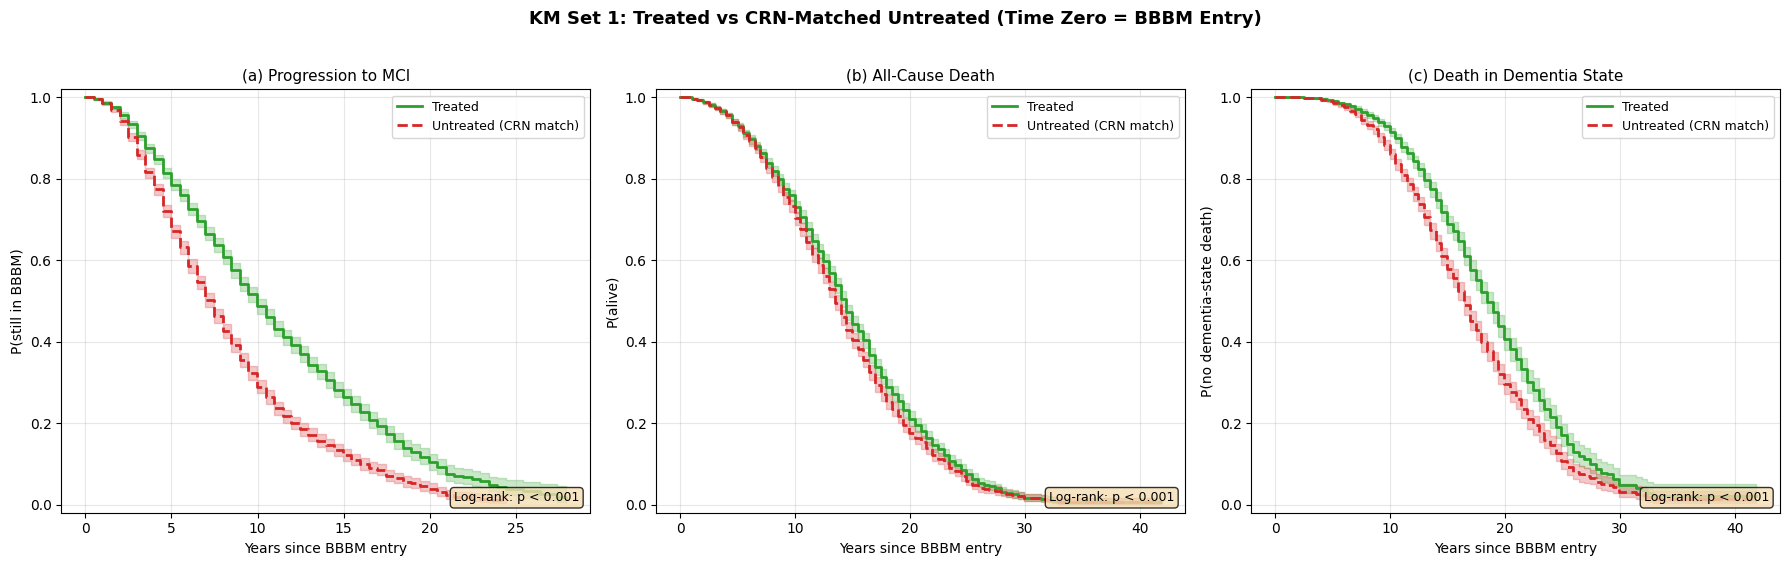


--- Log-rank test results ---
mci                 : test_statistic=292.82, p=1.21e-65
death               : test_statistic=11.59, p=0.0006644
dementia_death      : test_statistic=71.48, p=2.801e-17


In [7]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5.5))

titles = [
    '(a) Progression to MCI',
    '(b) All-Cause Death',
    '(c) Death in Dementia State',
]
ylabels = [
    'P(still in BBBM)',
    'P(alive)',
    'P(no dementia-state death)',
]
keys = ['mci', 'death', 'dementia_death']

results_1 = {}
for ax, key, title, ylabel in zip(axes, keys, titles, ylabels):
    d = km1_data[key]
    results_1[key] = plot_km_pair(
        ax,
        d['duration_t'], d['event_t'],
        d['duration_c'], d['event_c'],
        title=title, ylabel=ylabel,
    )

fig.suptitle('KM Set 1: Treated vs CRN-Matched Untreated (Time Zero = BBBM Entry)',
             fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print('\n--- Log-rank test results ---')
for key in keys:
    r = results_1[key]
    print(f'{key:20s}: test_statistic={r.test_statistic:.2f}, p={r.p_value:.4g}')

## KM Curve Set 2: Time Zero = Treatment Decision

**Within the treatment scenario**, compare simulants who accepted treatment
(entered `waiting_for_treatment` pipeline) vs those who refused
(entered `no_effect_never_treated`).

Time zero = when the simulant made the treatment decision.

**Caveat**: This is an observational comparison. Simulants are assigned to treatment
vs refusal based on `treatment_propensity`, which could confound if propensity
correlates with other risk factors (though in this model it's random).

In [8]:
def build_km_data_set2(treat_data, sim_end):
    """Build KM-ready DataFrames for Set 2 (time zero = treatment decision).
    
    Treated group: simulants who entered the treatment pipeline.
    Refused group: simulants who entered no_effect_never_treated.
    """
    records = {'mci': [], 'death': [], 'dementia_death': []}

    # Combine both groups
    all_sids = []
    for sid, t0 in treat_data['treatment_pipeline_time'].items():
        all_sids.append((sid, t0, 'treated'))
    for sid, t0 in treat_data['treatment_refusal_time'].items():
        # Only include refusers who were in BBBM
        if sid in treat_data['bbbm_enter_time']:
            all_sids.append((sid, t0, 'refused'))

    for sid, t0, group in all_sids:
        bbbm_exit = treat_data['bbbm_exit_time'].get(sid)
        bbbm_dest = treat_data['bbbm_exit_to'].get(sid)
        death = treat_data['death_time'].get(sid)
        disease_dead = treat_data['disease_at_death'].get(sid)

        # (a) MCI progression
        if bbbm_dest == 'mci' and bbbm_exit is not None:
            dur = (bbbm_exit - t0).days / 365.25
            evt = 1
        elif bbbm_dest == 'dead' and bbbm_exit is not None:
            dur = (bbbm_exit - t0).days / 365.25
            evt = 0
        else:
            dur = (sim_end - t0).days / 365.25
            evt = 0
        if dur > 0:
            records['mci'].append({'duration': dur, 'event': evt, 'group': group})

        # (b) All-cause death
        if death is not None:
            dur = (death - t0).days / 365.25
            evt = 1
        else:
            dur = (sim_end - t0).days / 365.25
            evt = 0
        if dur > 0:
            records['death'].append({'duration': dur, 'event': evt, 'group': group})

        # (c) Death in dementia state
        if death is not None and disease_dead == DEMENTIA_STATE:
            dur = (death - t0).days / 365.25
            evt = 1
        elif death is not None:
            dur = (death - t0).days / 365.25
            evt = 0
        else:
            dur = (sim_end - t0).days / 365.25
            evt = 0
        if dur > 0:
            records['dementia_death'].append({'duration': dur, 'event': evt, 'group': group})

    return {k: pd.DataFrame(v) for k, v in records.items()}

km2_data = build_km_data_set2(treat_data, sim_end)
for name, d in km2_data.items():
    n_treated = (d['group'] == 'treated').sum()
    n_refused = (d['group'] == 'refused').sum()
    print(f'{name:20s}: treated={n_treated}, refused={n_refused}')

mci                 : treated=3906, refused=5420
death               : treated=3906, refused=5420
dementia_death      : treated=3906, refused=5420


In [9]:
def plot_km_set2(ax, data, title='', ylabel='Survival probability'):
    """Plot KM curves for treated vs refused within treatment scenario."""
    kmf_t = KaplanMeierFitter()
    kmf_r = KaplanMeierFitter()

    t_mask = data['group'] == 'treated'
    r_mask = data['group'] == 'refused'

    kmf_t.fit(data.loc[t_mask, 'duration'], data.loc[t_mask, 'event'], label='Treated')
    kmf_r.fit(data.loc[r_mask, 'duration'], data.loc[r_mask, 'event'], label='Refused')

    kmf_t.plot_survival_function(ax=ax, color='#2ca02c', linewidth=2)
    kmf_r.plot_survival_function(ax=ax, color='#ff7f0e', linewidth=2, linestyle='--')

    result = logrank_test(
        data.loc[t_mask, 'duration'], data.loc[r_mask, 'duration'],
        data.loc[t_mask, 'event'], data.loc[r_mask, 'event'],
    )
    p = result.p_value
    p_str = f'p < 0.001' if p < 0.001 else f'p = {p:.3f}'
    ax.text(0.98, 0.02, f'Log-rank: {p_str}', transform=ax.transAxes,
            ha='right', va='bottom', fontsize=9,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='wheat', alpha=0.8))

    ax.set_title(title, fontsize=11)
    ax.set_xlabel('Years since treatment decision')
    ax.set_ylabel(ylabel)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(-0.02, 1.02)

    return result

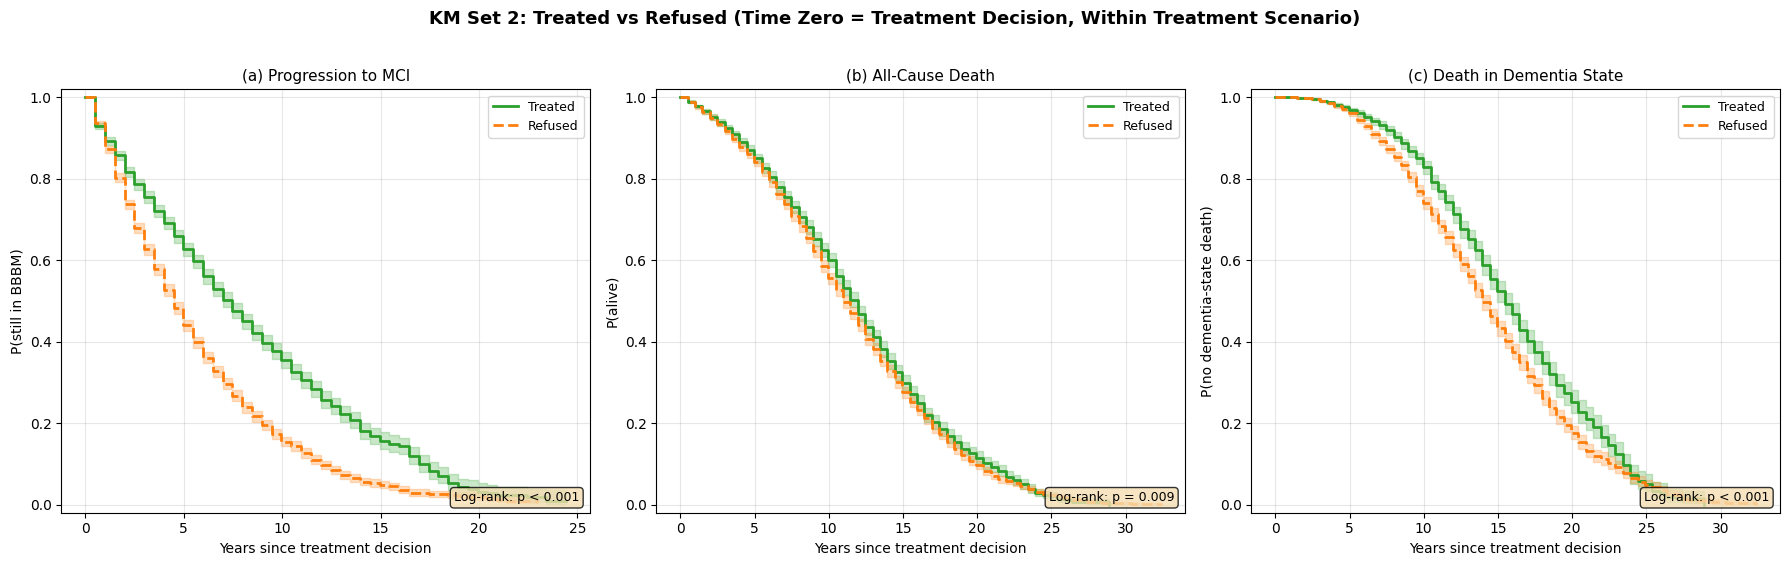


--- Log-rank test results ---
mci                 : test_statistic=398.28, p=1.302e-88
death               : test_statistic=6.75, p=0.009361
dementia_death      : test_statistic=52.11, p=5.239e-13


In [10]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5.5))

titles = [
    '(a) Progression to MCI',
    '(b) All-Cause Death',
    '(c) Death in Dementia State',
]
ylabels = [
    'P(still in BBBM)',
    'P(alive)',
    'P(no dementia-state death)',
]
keys = ['mci', 'death', 'dementia_death']

results_2 = {}
for ax, key, title, ylabel in zip(axes, keys, titles, ylabels):
    results_2[key] = plot_km_set2(
        ax, km2_data[key], title=title, ylabel=ylabel,
    )

fig.suptitle('KM Set 2: Treated vs Refused (Time Zero = Treatment Decision, Within Treatment Scenario)',
             fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print('\n--- Log-rank test results ---')
for key in keys:
    r = results_2[key]
    print(f'{key:20s}: test_statistic={r.test_statistic:.2f}, p={r.p_value:.4g}')

## Sankey Diagram: Why 71.8% Show Zero Benefit

Flow diagram tracing all uncensored treated simulants from BBBM entry
through treatment state to outcome (zero benefit vs has benefit).

Uses CRN-matched comparison: a simulant has "zero benefit" if their BBBM
duration is identical in both scenarios (additional_years == 0).

In [11]:
# Compute additional years for each treated simulant (uncensored only)
sankey_rows = []
for _, row in treated_df.iterrows():
    if row['bbbm_censored_t'] or row['bbbm_censored_c']:
        continue  # skip censored

    dur_t = (row['bbbm_exit_t'] - row['bbbm_enter_t']).days / 365.25
    dur_c = (row['bbbm_exit_c'] - row['bbbm_enter_c']).days / 365.25
    additional = dur_t - dur_c

    sankey_rows.append({
        'sid': row['sid'],
        'additional_years': additional,
        'has_benefit': additional > 0,
        'exit_to_t': row['bbbm_exit_to_t'],
        'tx_state_at_exit': row['tx_state_at_exit'],
    })

sankey_df = pd.DataFrame(sankey_rows)
n_total = len(sankey_df)
n_zero = (sankey_df['additional_years'] == 0).sum()
n_benefit = (sankey_df['additional_years'] > 0).sum()
print(f'Uncensored treated: {n_total}')
print(f'  Zero benefit: {n_zero} ({n_zero/n_total*100:.1f}%)')
print(f'  Has benefit:  {n_benefit} ({n_benefit/n_total*100:.1f}%)')

print(f'\nBBBM exit destination (treatment scenario):')
print(sankey_df['exit_to_t'].value_counts().to_string())

print(f'\nTreatment state at BBBM exit:')
print(sankey_df['tx_state_at_exit'].value_counts().to_string())

Uncensored treated: 3032
  Zero benefit: 2177 (71.8%)
  Has benefit:  855 (28.2%)

BBBM exit destination (treatment scenario):
exit_to_t
mci     2193
dead     839

Treatment state at BBBM exit:
tx_state_at_exit
treatment_effect             1583
waning_effect                1001
waiting_for_treatment         340
no_effect_after_treatment     108


In [12]:
# Categorize simulants for the Sankey diagram
# Level 1: All uncensored treated → Died in BBBM vs Alive MCI transition
died_bbbm = sankey_df[sankey_df['exit_to_t'] == 'dead']
alive_mci = sankey_df[sankey_df['exit_to_t'] == 'mci']

# Level 2 (for alive MCI): Treatment state at exit
# No protection (RR=1.0): waiting_for_treatment, no_effect_after_treatment
no_protection_states = ['waiting_for_treatment', 'no_effect_after_treatment', 'susceptible_to_treatment']
active_states = ['treatment_effect', 'waning_effect']

mci_no_protection = alive_mci[alive_mci['tx_state_at_exit'].isin(no_protection_states)]
mci_active = alive_mci[alive_mci['tx_state_at_exit'].isin(active_states)]

# Level 3 (for active treatment MCI exits): Zero benefit vs Has benefit
mci_active_zero = mci_active[~mci_active['has_benefit']]
mci_active_benefit = mci_active[mci_active['has_benefit']]

# Sanity check: no-protection should all be zero benefit
mci_no_prot_zero = mci_no_protection[~mci_no_protection['has_benefit']]
mci_no_prot_benefit = mci_no_protection[mci_no_protection['has_benefit']]

print('=== Sankey Flow Counts ===')
print(f'Total uncensored treated:            {n_total}')
print(f'  Died in BBBM:                      {len(died_bbbm)}')
print(f'  Alive → MCI transition:            {len(alive_mci)}')
print(f'    No protection (RR=1.0):          {len(mci_no_protection)}')
for state in no_protection_states:
    c = len(mci_no_protection[mci_no_protection['tx_state_at_exit'] == state])
    if c > 0:
        print(f'      {state}: {c}')
print(f'    Active treatment (RR<1.0):       {len(mci_active)}')
for state in active_states:
    c = len(mci_active[mci_active['tx_state_at_exit'] == state])
    if c > 0:
        print(f'      {state}: {c}')
print(f'      → Zero benefit (draw < p_treat): {len(mci_active_zero)}')
print(f'      → Has benefit (rescued):         {len(mci_active_benefit)}')
print(f'    No-protection with benefit:       {len(mci_no_prot_benefit)} (should be ~0)')

# Summary
total_zero = len(died_bbbm) + len(mci_no_prot_zero) + len(mci_active_zero)
total_benefit = len(mci_active_benefit) + len(mci_no_prot_benefit)
print(f'\nTotal zero benefit: {total_zero} ({total_zero/n_total*100:.1f}%)')
print(f'Total has benefit:  {total_benefit} ({total_benefit/n_total*100:.1f}%)')

=== Sankey Flow Counts ===
Total uncensored treated:            3032
  Died in BBBM:                      839
  Alive → MCI transition:            2193
    No protection (RR=1.0):          379
      waiting_for_treatment: 299
      no_effect_after_treatment: 80
    Active treatment (RR<1.0):       1814
      treatment_effect: 1161
      waning_effect: 653
      → Zero benefit (draw < p_treat): 1265
      → Has benefit (rescued):         549
    No-protection with benefit:       26 (should be ~0)

Total zero benefit: 2457 (81.0%)
Total has benefit:  575 (19.0%)


In [13]:
# Build Sankey diagram with plotly
# Nodes:
#  0: All Uncensored Treated
#  1: Died in BBBM
#  2: Alive → MCI
#  3: No Protection (RR=1.0)
#  4: Active Treatment (RR<1.0)
#  5: Zero Benefit
#  6: Has Benefit

labels = [
    f'All Uncensored Treated\n(n={n_total})',       # 0
    f'Died in BBBM\n(n={len(died_bbbm)})',          # 1
    f'Alive MCI Transition\n(n={len(alive_mci)})',   # 2
    f'No Protection (RR=1.0)\n(n={len(mci_no_protection)})',  # 3
    f'Active Treatment (RR<1.0)\n(n={len(mci_active)})',      # 4
    f'Zero Benefit\n(n={total_zero})',               # 5
    f'Has Benefit\n(n={total_benefit})',              # 6
]

# Links: source → target with value
sources = [0, 0, 2, 2, 1, 3, 3, 4, 4]
targets = [1, 2, 3, 4, 5, 5, 6, 5, 6]
values = [
    len(died_bbbm),         # 0→1: All treated → Died in BBBM
    len(alive_mci),         # 0→2: All treated → Alive MCI
    len(mci_no_protection), # 2→3: Alive MCI → No Protection
    len(mci_active),        # 2→4: Alive MCI → Active Treatment
    len(died_bbbm),         # 1→5: Died in BBBM → Zero Benefit
    len(mci_no_prot_zero),  # 3→5: No Protection → Zero Benefit
    len(mci_no_prot_benefit),  # 3→6: No Protection → Has Benefit
    len(mci_active_zero),   # 4→5: Active Treatment → Zero Benefit
    len(mci_active_benefit),# 4→6: Active Treatment → Has Benefit
]

# Colors
node_colors = [
    '#3498db',  # All treated - blue
    '#95a5a6',  # Died in BBBM - gray
    '#3498db',  # Alive MCI - blue
    '#e67e22',  # No protection - orange
    '#2ecc71',  # Active treatment - green
    '#e74c3c',  # Zero benefit - red
    '#27ae60',  # Has benefit - dark green
]

link_colors = [
    'rgba(149,165,166,0.4)',  # → Died
    'rgba(52,152,219,0.4)',   # → Alive MCI
    'rgba(230,126,34,0.4)',   # → No Protection
    'rgba(46,204,113,0.4)',   # → Active Treatment
    'rgba(231,76,60,0.4)',    # Died → Zero
    'rgba(231,76,60,0.4)',    # No Prot → Zero
    'rgba(39,174,96,0.4)',    # No Prot → Benefit
    'rgba(231,76,60,0.4)',    # Active → Zero
    'rgba(39,174,96,0.4)',    # Active → Benefit
]

fig = go.Figure(data=[go.Sankey(
    arrangement='snap',
    node=dict(
        pad=20,
        thickness=25,
        label=labels,
        color=node_colors,
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values,
        color=link_colors,
    ),
)])

fig.update_layout(
    title=dict(
        text='Why 71.8% of Treated Simulants Show Zero Additional Preclinical Years',
        font=dict(size=16),
    ),
    font=dict(size=12),
    width=900,
    height=500,
)
fig.show()

## Summary Statistics

In [14]:
print('=' * 70)
print('KM & SANKEY ANALYSIS SUMMARY')
print('=' * 70)

print(f'\nSimulation: 2022-{TARGET_YEAR}, population={POPULATION_SIZE:,}')
print(f'Matched treated simulants: {len(treated_df)}')
print(f'  Uncensored (exited BBBM in both scenarios): {n_total}')

print(f'\n--- KM Set 1: Time Zero = BBBM Entry (Treated vs CRN-Matched Untreated) ---')
for key in ['mci', 'death', 'dementia_death']:
    r = results_1[key]
    sig = 'YES' if r.p_value < 0.05 else 'NO'
    print(f'  {key:20s}: chi2={r.test_statistic:7.2f}, p={r.p_value:.4g} (significant: {sig})')

print(f'\n--- KM Set 2: Time Zero = Treatment Decision (Treated vs Refused) ---')
for key in ['mci', 'death', 'dementia_death']:
    r = results_2[key]
    sig = 'YES' if r.p_value < 0.05 else 'NO'
    print(f'  {key:20s}: chi2={r.test_statistic:7.2f}, p={r.p_value:.4g} (significant: {sig})')

print(f'\n--- Sankey: Zero-Benefit Breakdown ---')
print(f'  Total uncensored treated:          {n_total}')
print(f'  Died in BBBM → zero benefit:       {len(died_bbbm):>5d} ({len(died_bbbm)/n_total*100:.1f}%)')
print(f'  No protection (RR=1) → zero:       {len(mci_no_prot_zero):>5d} ({len(mci_no_prot_zero)/n_total*100:.1f}%)')
print(f'  Active treatment → zero (CRN):     {len(mci_active_zero):>5d} ({len(mci_active_zero)/n_total*100:.1f}%)')
print(f'  Active treatment → has benefit:     {len(mci_active_benefit):>5d} ({len(mci_active_benefit)/n_total*100:.1f}%)')
print(f'  ──────────────────────────────────────')
print(f'  Total zero benefit:                {total_zero:>5d} ({total_zero/n_total*100:.1f}%)')
print(f'  Total has benefit:                 {total_benefit:>5d} ({total_benefit/n_total*100:.1f}%)')

KM & SANKEY ANALYSIS SUMMARY

Simulation: 2022-2070, population=10,000
Matched treated simulants: 3969
  Uncensored (exited BBBM in both scenarios): 3032

--- KM Set 1: Time Zero = BBBM Entry (Treated vs CRN-Matched Untreated) ---
  mci                 : chi2= 292.82, p=1.21e-65 (significant: YES)
  death               : chi2=  11.59, p=0.0006644 (significant: YES)
  dementia_death      : chi2=  71.48, p=2.801e-17 (significant: YES)

--- KM Set 2: Time Zero = Treatment Decision (Treated vs Refused) ---
  mci                 : chi2= 398.28, p=1.302e-88 (significant: YES)
  death               : chi2=   6.75, p=0.009361 (significant: YES)
  dementia_death      : chi2=  52.11, p=5.239e-13 (significant: YES)

--- Sankey: Zero-Benefit Breakdown ---
  Total uncensored treated:          3032
  Died in BBBM → zero benefit:         839 (27.7%)
  No protection (RR=1) → zero:         353 (11.6%)
  Active treatment → zero (CRN):      1265 (41.7%)
  Active treatment → has benefit:       549 (18.1%)